# Baseline with Neural Operator Library

In [1]:
import pathlib
import torch
from torch.utils.data import Subset, random_split
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from neuralop.models import FNO
from neuralop.training import AdamW
from neuralop import LpLoss, H1Loss
from neuralop.training.incremental import IncrementalFNOTrainer
from neuralop.data.transforms.data_processors import IncrementalDataProcessor
from tqdm.notebook import tqdm
from IPython.display import HTML

from acoustic_no.data import AcousticDataset

In [2]:
# Use the GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
DEPTH = 64

In [4]:
# Load the dataset
dataset = AcousticDataset(
    data_dir=pathlib.Path("../resources/dataset/checkpoints"),
    depth=DEPTH,
)
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# Use a random subset of the dataset for training
N_TRAIN, N_VAL = 1024, 16
idx_train = torch.randperm(len(train_dataset))[:N_TRAIN]
train_dataset = Subset(train_dataset, idx_train)
idx_val = torch.randperm(len(val_dataset))[:N_VAL]
val_dataset = Subset(val_dataset, idx_val)
# Create a data loader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
)
val_loader = {
    "64x64": torch.utils.data.DataLoader(
        val_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=0,
    )
}
# Create a data processor

In [5]:
model = FNO(
    n_modes=(16, 16),
    in_channels=DEPTH * 3 + 1,
    out_channels=DEPTH,
    hidden_channels=64,
    projection_channel_ratio=2,
)
model.to(device)

FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([64, 64, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
          (1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(195, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(128, 64, kernel

In [6]:
optimizer = AdamW(model.parameters(),
                                lr=8e-3,
                                weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [7]:
data_transform = IncrementalDataProcessor(
    in_normalizer=None,
    out_normalizer=None,
    device=device,
    subsampling_rates=[8, 4, 2, 1],
    dataset_resolution=64,
    dataset_indices=[2, 3],
    epoch_gap=8,
    verbose=True,
)

data_transform = data_transform.to(device)

Original Incre Res: change index to 0
Original Incre Res: change sub to 8
Original Incre Res: change res to 8


In [8]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)
train_loss = h1loss
eval_losses = {"h1": h1loss, "l2": l2loss}

# Finally pass all of these to the Trainer
trainer = IncrementalFNOTrainer(
    model=model,
    n_epochs=32,
    data_processor=data_transform,
    device=device,
    verbose=True,
    incremental_loss_gap=False,
    incremental_grad=True,
    incremental_grad_eps=0.9999,
    incremental_loss_eps = 0.001,
    incremental_buffer=5,
    incremental_max_iter=1,
    incremental_grad_max_iter=2,
)

trainer.train(
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,
)

Training on 1024 samples
Testing on [16] samples         on resolutions ['64x64'].
Raw outputs of shape torch.Size([16, 64, 8, 8])
[0] time=6.24, avg_loss=36.2229, train_err=579.5668
Eval: 64x64_h1=38.5303, 64x64_l2=36.8323
[1] time=6.07, avg_loss=27.3052, train_err=436.8836
Eval: 64x64_h1=37.4344, 64x64_l2=34.4382
[2] time=6.33, avg_loss=23.8463, train_err=381.5405
Eval: 64x64_h1=39.8761, 64x64_l2=35.7716
[3] time=6.80, avg_loss=22.0161, train_err=352.2572
Eval: 64x64_h1=36.6644, 64x64_l2=33.0977
[4] time=6.34, avg_loss=20.4362, train_err=326.9791
Eval: 64x64_h1=37.9524, 64x64_l2=34.1570
[5] time=5.77, avg_loss=19.0712, train_err=305.1397
Eval: 64x64_h1=38.1505, 64x64_l2=34.7779
[6] time=5.75, avg_loss=18.0191, train_err=288.3049
Eval: 64x64_h1=36.1568, 64x64_l2=32.2784
[7] time=5.63, avg_loss=17.1230, train_err=273.9674
Eval: 64x64_h1=37.5876, 64x64_l2=34.0865
Incre Res Update: change index to 1
Incre Res Update: change sub to 4
Incre Res Update: change res to 16
[8] time=14.15, avg_

{'train_err': 274.89892625808716,
 'avg_loss': 17.181182891130447,
 'avg_lasso_loss': None,
 'epoch_train_time': 153.53091037506238,
 '64x64_h1': tensor(20.1479),
 '64x64_l2': tensor(17.9744)}

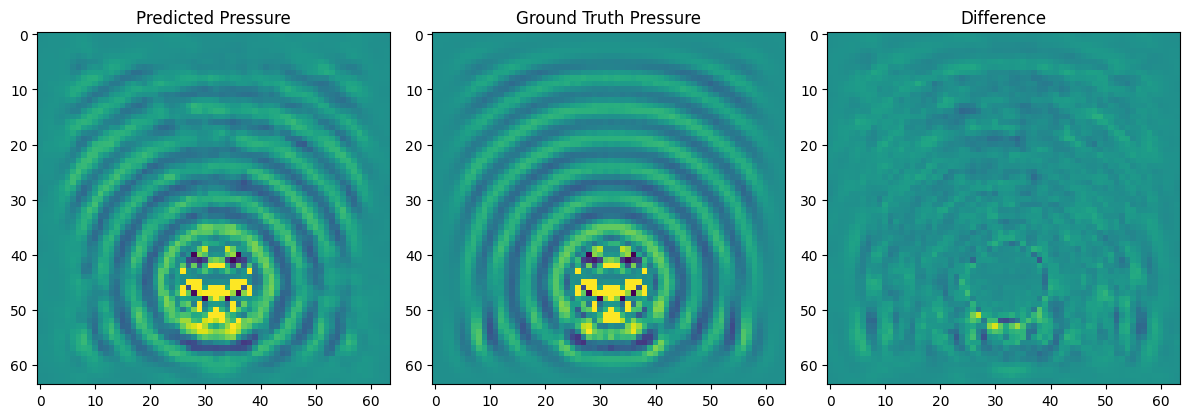

In [15]:
# Inference
model.eval()
eval_data = val_dataset[0]
x = eval_data["x"]
p = eval_data["y"]
v = eval_data["v"]
a = eval_data["a"]
with torch.no_grad():
    pred = model(x.unsqueeze(0).to(device))

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(pred[0, -1].cpu().numpy(), cmap='viridis', vmin=-10, vmax=10)
ax[0].set_title("Predicted Pressure")
ax[1].imshow(p[-1].cpu().numpy(), cmap='viridis', vmin=-10, vmax=10)
ax[1].set_title("Ground Truth Pressure")
ax[2].imshow(pred[0, -1].cpu().numpy() - p[-1].cpu().numpy(), cmap='viridis', vmin=-10, vmax=10)
ax[2].set_title("Difference")
plt.tight_layout()
plt.show()


Animation Progress:   0%|          | 0/64 [00:00<?, ?step/s]

MovieWriter imagemagick unavailable; using Pillow instead.


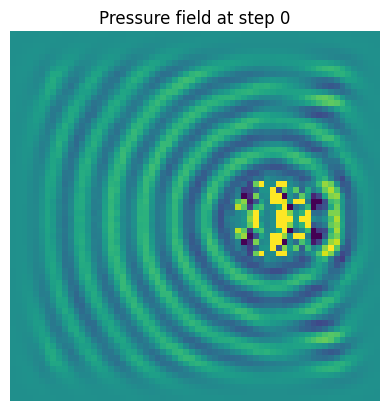

In [12]:
# Tqdm progress bar for the simulation
pbar = tqdm(total=DEPTH, desc="Animation Progress", unit="step")

# Generate the animation for the pressure field.
def update(frame):
    ax.clear()
    im = ax.imshow(
        p.cpu()[frame].T,
        interpolation='nearest',
        vmin=-10.0,
        vmax=10.0
    )
    ax.set_title(f'Pressure field at step {frame}')
    ax.axis('off')
    # Update the progress bar
    pbar.update(1)
    # Close the progress bar when done
    if frame == DEPTH - 1:
        pbar.close()
    return [im]

fig, ax = plt.subplots()

# Wrap the animation generation with tqdm for progress tracking
ani = FuncAnimation(
    fig,
    update,
    frames=range(DEPTH),
    interval=1000 / 60,
    blit=False,
    repeat=True,
)

# Save gif
ani.save("pressure_field.gif", fps=60, writer='imagemagick')
# Display the animation in the notebook
HTML(ani.to_jshtml())

Animation Progress:   0%|          | 0/64 [00:00<?, ?step/s]

MovieWriter imagemagick unavailable; using Pillow instead.


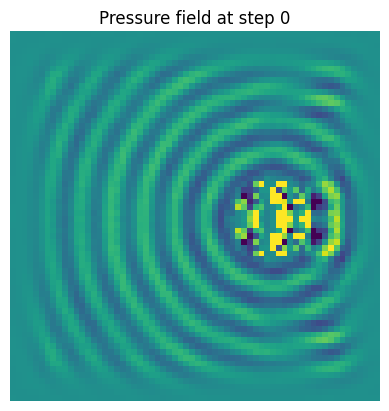

In [13]:
# Tqdm progress bar for the simulation
pbar = tqdm(total=DEPTH, desc="Animation Progress", unit="step")

# Generate the animation for the pressure field.
def update(frame):
    ax.clear()
    im = ax.imshow(
        pred.cpu()[0, frame].T,
        interpolation='nearest',
        vmin=-10.0,
        vmax=10.0
    )
    ax.set_title(f'Pressure field at step {frame}')
    ax.axis('off')
    # Update the progress bar
    pbar.update(1)
    # Close the progress bar when done
    if frame == DEPTH - 1:
        pbar.close()
    return [im]

fig, ax = plt.subplots()

# Wrap the animation generation with tqdm for progress tracking
ani = FuncAnimation(
    fig,
    update,
    frames=range(DEPTH),
    interval=1000 / 60,
    blit=False,
    repeat=True,
)

# Save gif
ani.save("pred_pressure_field.gif", fps=60, writer='imagemagick')
# Display the animation in the notebook
HTML(ani.to_jshtml())